## Impact of variables on convection

In [1]:
import numpy as np
import netCDF4 as nc
import glob
import os

import matplotlib as mpl
font = {'family' : 'sans',
        'size'   : 12}

mpl.rc('font', **font)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator, LogLocator, MaxNLocator
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt

import pandas as pd
from cmcrameri import cm


In [2]:
R_earth = 6.371e6 # m

In [3]:
from proteus.config import read_config
import utils.load_grid as lg

In [4]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'

# %matplotlib widget

In [5]:
def readrun(f, stride=1):
    print("Reading files in '%s'..." % f, end='')
    ncdfs = glob.glob(f+"/data/*_atm.nc")
    if len(ncdfs) == 0:
        raise Exception("No files found!")

    years = [float(s.split("/")[-1].split("_")[0]) for s in ncdfs]

    if stride < 0:
        mask = [np.argsort(years)[-1]]
    else:
        mask = np.argsort(years)[::int(stride)]

    ncdfs = np.array([ncdfs[i] for i in mask])
    years = np.array([years[i] for i in mask])
    data  = np.array([lg.readncdf(f) for f in ncdfs])

    print("    Final time = %1.3e years" % years[-1])
    return years, data

def read_helpfile(fpath):
    return pd.read_csv(fpath, sep=r'\s+')



### Do analysis

In [6]:
def load_grid(pgrid_dir):

    globber = pgrid_dir + "/case_*/"
    print(globber)
    cases = glob.glob(globber)

    npoints = len(cases)
    print("npoints = %d"%npoints)
    if npoints < 1:
        raise

    out = {
        "data": [],
        "help": [],
        "conf": [],
        "post": [],
        "cnum": [],
        "stat": lg.get_statuses(pgrid_dir),
        "npts": npoints
    }

    for folder in cases:
        _,d = readrun(folder, stride=-1)
        out["data"].append( d )
        out["conf"].append( read_config(folder+"init_coupler.toml") )
        out["help"].append( read_helpfile(folder+"runtime_helpfile.csv") )
        out["cnum"].append(int(folder.split("_")[-1].replace("/","")))

    print("Done")
    return out



In [ ]:
lov  = load_grid("data/output/LOV_c/")
noh  = load_grid("data/output/NOH_c/")

data/output/LOV_d//case_*/
npoints = 100


Reading files in 'data/output/LOV_d/case_00000/'...    Final time = 5.019e+06 years
Reading files in 'data/output/LOV_d/case_00001/'...    Final time = 5.214e+06 years
Reading files in 'data/output/LOV_d/case_00002/'...    Final time = 2.075e+06 years
Reading files in 'data/output/LOV_d/case_00003/'...    Final time = 1.621e+06 years
Reading files in 'data/output/LOV_d/case_00004/'...    Final time = 1.290e+06 years
Reading files in 'data/output/LOV_d/case_00005/'...    Final time = 1.045e+06 years
Reading files in 'data/output/LOV_d/case_00006/'...    Final time = 3.694e+06 years
Reading files in 'data/output/LOV_d/case_00007/'...    Final time = 1.161e+06 years
Reading files in 'data/output/LOV_d/case_00008/'...    Final time = 6.781e+05 years
Reading files in 'data/output/LOV_d/case_00009/'...    Final time = 3.938e+05 years
Reading files in 'data/output/LOV_d/case_00010/'...    Final time = 4.645e+06 years
Reading files in 'data/output/LOV_d/case_00011/'...    Final time = 3.433e+0

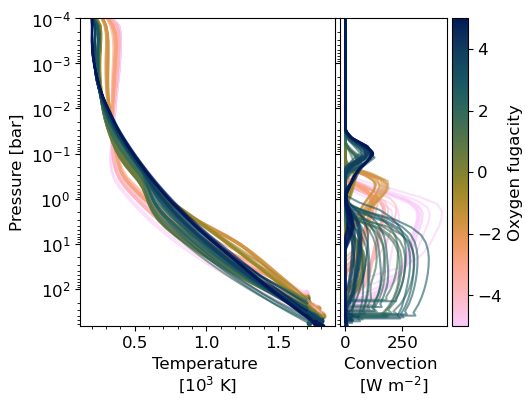

In [39]:
plt.close("all")
fig,axs = plt.subplots(1,2, sharey=True, width_ratios=(0.6, 0.3), figsize=(5,4))
(ax0,ax1) = axs

al = 0.6

z_key = "outgas.fO2_shift_IW"
z_lbl = "Oxygen fugacity"
z_log = False
cmap = cm.batlow_r

z_arr = []
for i in range(lov["npts"]):
    if "." in z_key:
        z_arr.append(lg.descend_get(lov["conf"][i],z_key))
    else:
        z_arr.append(np.array(lov["help"][i][z_key][:])[-1])
z_arr = np.array(z_arr)

if z_log:
    norm = mpl.colors.LogNorm(vmin=np.log10(np.amin(z_arr[z_arr>0])), vmax=np.log10(np.amax(z_arr)))
else:
    norm = mpl.colors.Normalize(vmin=np.amin(z_arr), vmax=np.amax(z_arr))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

p_max = 1.0
p_min = 0.1
for i in range(lov["npts"]):
    ds = lov["data"][i][-1]
    st = lov["stat"][lov["cnum"][i]]

    x = ds["tmpl"][:] / 1e3
    y = ds["pl"][:] * 1e-5
    c = ds["fl_cnvct"][:]
    p_max = max(p_max,y[-1])
    p_min = min(p_min,y[0])

    # if not (10 <= st <= 19 ):
    #     print("Skip case %d"%cnum[i])
    #     continue

    col = sm.to_rgba(z_arr[i])

    ax0.plot(x,y, color=col, alpha=al)
    ax0.scatter(x[-1],y[-1], color=col, s=10)

    ax1.plot(c,y, color=col, alpha=al)

ax0.set_yscale("log")
ax0.set_ylim(bottom=p_max, top=p_min)
ax0.set_ylabel("Pressure [bar]")
ax0.set_xlabel("Temperature \n" + r"[$10^3$ K]")
ax0.xaxis.set_major_locator(MultipleLocator(0.5))
ax0.xaxis.set_minor_locator(MultipleLocator(0.1))

ax1.set_xlabel("Convection \n" + r"[W m$^{-2}$]")
# ax1.xaxis.set_major_locator(MultipleLocator(1.0))
# ax1.xaxis.set_minor_locator(MultipleLocator(0.5))

cax = make_axes_locatable(ax1).append_axes('right', size='15%', pad=0.05)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical', norm=norm)
cbar.set_label(z_lbl)

fig.subplots_adjust(wspace=0.03)
plt.show()

In [13]:
def upsamp(x,y, bins=300):
    itp = PchipInterpolator(x,y)
    xx = np.logspace(np.log10(x[0]), np.log10(x[-1]), bins)
    return xx,itp(xx)

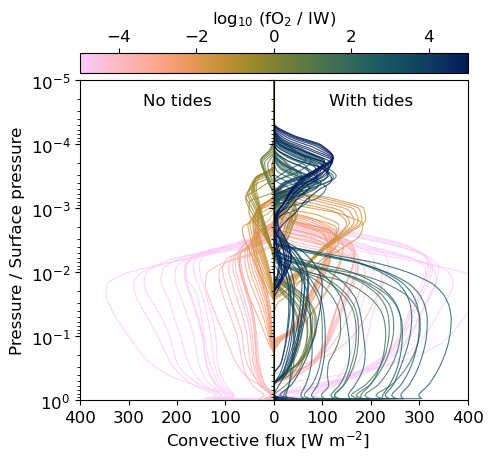

In [69]:
figscale=1
fig,axs = plt.subplots(1,2, sharey=True, figsize=(5*figscale,5*figscale))
(ax0,ax1) = axs

al = 0.8
lw = 0.8

z_key = "outgas.fO2_shift_IW"
z_lbl = r"log$_{10}$ (fO$_{2}$ / IW)"
z_log = False
cmap = cm.batlow_r
xmax = 400
dx   = 100
ylim = (1,1e-5)

xticks = np.arange(dx, xmax+dx, dx)

z_arr = []
for i in range(lov["npts"]):
    if "." in z_key:
        z_arr.append(lg.descend_get(lov["conf"][i],z_key))
    else:
        z_arr.append(np.array(lov["help"][i][z_key][:])[-1])
z_arr = np.array(z_arr)

if z_log:
    norm = mpl.colors.LogNorm(vmin=np.log10(np.amin(z_arr[z_arr>0])), vmax=np.log10(np.amax(z_arr)))
else:
    norm = mpl.colors.Normalize(vmin=np.amin(z_arr), vmax=np.amax(z_arr))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for i in range(lov["npts"]):
    ds = lov["data"][i][-1]
    y = ds["pl"][:] * 1e-5
    x = ds["fl_cnvct"][:]
    ymax = max(ymax,y[-1])
    if np.sum(x) > 1e-9:
        col = sm.to_rgba(z_arr[i])
        y,x = upsamp(y,x)
        ax1.plot(x,y/y[-1], color=col, alpha=al, lw=lw)

for i in range(noh["npts"]):
    ds = noh["data"][i][-1]
    x = ds["fl_cnvct"][:]
    y = ds["pl"][:] * 1e-5
    ymax = max(ymax,y[-1])
    if np.sum(x) > 1e-9:
        if "." in z_key:
            this_z = lg.descend_get(noh["conf"][i], z_key)
        else:
            this_z = list(noh["help"][i][z_key])[-1]
        y,x = upsamp(y,x)
        ax0.plot(x,y/y[-1], color=sm.to_rgba(this_z), alpha=al, lw=lw)

ax0.set_yscale("log")
ax0.set_ylabel("Pressure / Surface pressure")
ax0.set_ylim(ylim)
ax0.set_xlim(left=xmax, right=0)
ax0.set_xticks(np.append([0],xticks))
ax1.set_xlim(right=xmax, left=0)
ax1.set_xticks(xticks[::-1])
fig.supxlabel(r"Convective flux [W m$^{-2}$]", fontsize=12)


for i,txt in enumerate(("No tides","With tides")):
    axs[i].text(0.5, 0.96, txt, zorder=12,
                horizontalalignment='center', verticalalignment='top',
                transform=axs[i].transAxes, fontsize=12).set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

cbar = fig.colorbar(sm, ax=axs, orientation='horizontal', location='top', pad=0.05)
cbar.set_label(z_lbl)

fig.subplots_adjust(wspace=0.0, top=0.75)
plt.show()
fig.savefig("output/tides_convect.pdf", bbox_inches='tight')